## MNIST classification with Convolutional neural networks


### Importing libraries

In [47]:
import tensorflow as tf
from tensorflow.contrib import learn
import numpy as np
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.INFO)

### Get MNIST data
The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

In [48]:
mnist = learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


### MNIST training data
each sample on the MNIST dataset consist on a 784 feature vector encoding a 28x28 grayscale image. 

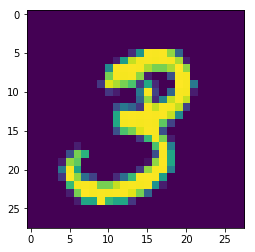

In [49]:
import matplotlib.pyplot as plt
imgDigit = mnist.train.images[1]
plt.imshow(imgDigit.reshape([28,28]))
plt.show()

### Creating our CNN model

In [50]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    loss = None
    train_op = None

    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
        loss = tf.losses.softmax_cross_entropy(
            onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(loss=loss,global_step=tf.contrib.framework.get_global_step(),
                                                   learning_rate=0.001,optimizer="SGD")

    # Generate Predictions
    predictions = {"classes": tf.argmax(input=logits, axis=1),
                   "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

    # Return a ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [51]:
# Create the Estimator
mnist_classifier = learn.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6f276460b8>, '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_evaluation_master': '', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_task_type': None, '_task_id': 0, '_master': ''}


In [52]:
# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

In [53]:
# Train the model
mnist_classifier.fit(x=train_data,
                     y=train_labels,
                     batch_size=100,
                     steps=20000,
                     monitors=[logging_hook])


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/usr/local/lib/python3.4/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 2.30814, step = 1
INFO:tensorflow:probabilities = [[ 0.11068404  0.10692676  0.09727906  0.09338617  0.0977428   0.0994721
   0.09452058  0.08726695  0.11736263  0.0953589 ]
 [ 0.10361801  0.10705881  0.08971094  0.10134704  0.08937748  0.10016651
   0.10860749  0.08958712  0.10951389  0.10101257]
 [ 0.09418362  0.10927244  0.10496791  0.09345593  0.10049982  0.10372023
   0.10859322  0.08899346  0.10614985  0.09016351]
 [ 0.10724962  0.11251541  0.08628592  0.10920798  0.08674364  0.11345102
   0.10140762  0.08955096  0.10263702  0.09095078]
 [ 0.10227022  0.11652385  0.09076774  0.09452596  0.09458482  0.10545645
   0.10778105  0.08177896  0.10268568  0.10362532]
 [ 0.10251254  0.10269582  0.09199355  0.09463386  0.08379332  0.10596164
   0.12094779  0.0916085   0.1005801   0.10527295]
 [ 0.09533645  0.10723229  0.10176505  0.09172627  

Estimator(params=None)

In [57]:
# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes"),}

# Evaluate the model and print results
eval_results = mnist_classifier.evaluate(x=eval_data, y=eval_labels, metrics=metrics)
print(eval_results)


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/usr/local/lib/python3.4/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Starting evaluation at 2017-02-17-15:56:41
INFO:tensorflow:Finished evaluation at 2017-02-17-15:56:49
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9701, global_step = 20000, loss = 0.100971
{'accuracy': 0.97009999, 'loss': 0.1009706, 'global_step': 20000}
